In [1]:
import pandas as pd

'''
'overall' = 買家對產品的評分
'verified' = true
'reviewTime' = 評論的時間
'reviewerID' = 評論ID
'asin' = 產品ID
'style' = 產品的特徵
'reviewerName' = 評論ID的名字
'reviewText' = 評論的內容
'summary' = 評論內容的總結
'unixReviewTime' = 評論的格林威治時間
'''

fin = open('/content/Magazine_Subscriptions.json')

review_list=[]
for line in fin:
  d = eval(line,{'true':True,'false':False,'null':None})
  if 'reviewText' in d.keys() and 'summary' in d.keys():
      review_list.append([d['reviewerID'], d['asin'], d['overall'], d['reviewTime'], d['reviewText'], d['summary']])
df = pd.DataFrame(review_list, columns=['user_id', 'item_id', 'score','reviewTime', 'review_text','summary'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89640 entries, 0 to 89639
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      89640 non-null  object 
 1   item_id      89640 non-null  object 
 2   score        89640 non-null  float64
 3   reviewTime   89640 non-null  object 
 4   review_text  89640 non-null  object 
 5   summary      89640 non-null  object 
dtypes: float64(1), object(5)
memory usage: 4.1+ MB
None


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random as rn
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [3]:
def score_round(x):
    if x>=3:
        return 1
    else:
        return 0

In [4]:
df['review_score']= df.score.apply(score_round)
print(df.head())

          user_id     item_id  score   reviewTime  \
0   AH2IFH762VY5U  B00005N7P0    5.0   11 8, 2001   
1   AOSFI0JEYU4XM  B00005N7P0    5.0  10 31, 2001   
2  A3JPFWKS83R49V  B00005N7OJ    3.0  03 24, 2007   
3  A19FKU6JZQ2ECJ  B00005N7OJ    5.0  11 10, 2006   
4  A25MDGOMZ2GALN  B00005N7P0    5.0  07 14, 2014   

                                         review_text  \
0  for computer enthusiast, MaxPC is a welcome si...   
1  Thank god this is not a Ziff Davis publication...   
2  Antiques Magazine is a publication made for an...   
3  This beautiful magazine is in itself a work of...   
4                          A great read every issue.   

                                           summary  review_score  
0           AVID READER SINCE "boot"  WAS THE NAME             1  
1                               The straight scoop             1  
2  Antiques Magazine is Good, but not for Everyone             1  
3                           THE  DISCERNING READER             1  
4        

In [5]:
df.review_text = df.review_text.astype('str')
df.summary = df.summary.astype('str')

In [6]:
df.isnull().sum()

user_id         0
item_id         0
score           0
reviewTime      0
review_text     0
summary         0
review_score    0
dtype: int64

In [8]:
df['review_score'].value_counts()

review_score
1    73390
0    16250
Name: count, dtype: int64

In [7]:
def cleanlink(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)#'>'
    result = re.sub('&lt;', "", result)#'<'
    result = re.sub('&#x27;', "'", result)#'''
    result = re.sub('&quot;', '"', result)#'"'
    result = re.sub('&apos;', '"', result)#'''
    result = re.sub('&#x2F;', "", result)#'/'
    result = re.sub('<p>', "", result)#''
    result = re.sub('</p>', "", result)#''
    result = re.sub('<i>', "", result)#''
    result = re.sub('</i>', "", result)#''
    result = re.sub("\n", "", result)
    return result

def remove_num(texts):
   output = re.sub(r'\d+', '', texts)
   return output

def remove_mouse(texts):
   output = re.sub(r"[\w\.\-\_]+@[\w\.\-\_]+", '', texts)
   return output

def remove_symbols(texts):
    output = re.sub(r"[^a-zA-Z0-9]+", ' ', texts)
    return output

def unify_whitespaces(texts):
    cleaned_string = re.sub(' +', ' ', texts)
    return cleaned_string

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop = set(stopwords.words('english'))

def remove_stopword(texts):
   text=[word.lower() for word in texts.split() if word.lower() not in stop]
   return " ".join(text)

def remove_emoji(texts):
    output = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                              "]+", flags=re.UNICODE)
    return output.sub(r'', texts)

def cleaning(df,review):
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(cleanlink)
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_mouse)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(unify_whitespaces)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(remove_emoji)

cleaning(df,'review_text')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = [word.lower() for word in text.split()]
    lemmatizer_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(lemmatizer_tokens)
df['review_text'] = df['review_text'].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
df['review_text']

0        computer enthusiast maxpc welcome sight mailbo...
1        thank god ziff davis publication maxpc actuall...
2        antique magazine publication made antique love...
3        beautiful magazine work art quality every page...
4                                   great read every issue
                               ...                        
89635    nice surprise boyfriend really enjoyed olympic...
89636    magazine look like printed recycled shoe rubbe...
89637            cant go wrong si subscriptionvery pleased
89638    magazine far time favorite one metal detecting...
89639                      nice magazine good info article
Name: review_text, Length: 89640, dtype: object

In [11]:
reviews = df["review_text"].values.tolist()
labels = df["review_score"].tolist()

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tokenizers import BertWordPieceTokenizer

import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import coo_matrix, hstack
from sklearn.naive_bayes import MultinomialNB

import logging
transformers.logging.set_verbosity_error()

In [13]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train, Y_test = train_test_split(df['review_text'], df['review_score'], test_size=0.25, random_state=30)
print('Train: ',X_train.shape,Y_train.shape,'Test: ',(X_test.shape,Y_test.shape))

Train:  (67230,) (67230,) Test:  ((22410,), (22410,))


In [14]:
print('TFIDF Vectorizer......')
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer= TfidfVectorizer()
tf_x_train = vectorizer.fit_transform(X_train)
tf_x_test = vectorizer.transform(X_test)

TFIDF Vectorizer......


In [15]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='minority')
tf_x_train_s, Y_train_s = sm.fit_resample(tf_x_train, Y_train)

In [20]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
model = RandomForestClassifier()
#cv_results = cross_val_score(model, tf_x_train,Y_train, cv=kfold)

#print("Cross-validation scores:", cv_results)
#print("Mean accuracy:", np.mean(cv_results))

fold_scores = []
for fold, (train_index, test_index) in enumerate(kfold.split(tf_x_train_s)):
    X_train, X_test = tf_x_train_s[train_index], tf_x_train_s[test_index]
    y_train, y_test = np.array(Y_train_s)[train_index], np.array(Y_train_s)[test_index]

    # 训练模型
    model.fit(X_train, y_train)

    # 评估模型
    score = model.score(X_test, y_test)
    fold_scores.append(score)

    # 打印每个 fold 的分数
    print(f"Fold {fold+1} - Score: {score}")

# 打印所有 fold 的分数
print("All fold scores:", fold_scores)
print("Mean accuracy:", np.mean(fold_scores))

Fold 1 - Score: 0.9404978197674418
Fold 2 - Score: 0.9415879360465116
Fold 3 - Score: 0.9459484011627907
Fold 4 - Score: 0.9424963662790697
Fold 5 - Score: 0.9415879360465116
Fold 6 - Score: 0.9474018895348837
Fold 7 - Score: 0.9414009266830199
Fold 8 - Score: 0.9434905060416099
Fold 9 - Score: 0.9425819932770055
Fold 10 - Score: 0.9433088034886891
All fold scores: [0.9404978197674418, 0.9415879360465116, 0.9459484011627907, 0.9424963662790697, 0.9415879360465116, 0.9474018895348837, 0.9414009266830199, 0.9434905060416099, 0.9425819932770055, 0.9433088034886891]
Mean accuracy: 0.9430302578327533


In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score, f1_score, precision_score, recall_score

y_test_pred=model.predict(tf_x_test)
y_pred_proba = model.predict_proba(tf_x_test)[:,1]
print ('\n')
print ("Model Final Generalization roc_auc_score: %.6f" %roc_auc_score(Y_test,y_pred_proba))
print ("Model Final Generalization ACC: %.6f" %accuracy_score(Y_test,y_test_pred))
print ("Model Final Generalization F1: %.6f" %f1_score(Y_test,y_test_pred))
print ("Model Final Generalization precision: %.6f" %precision_score(Y_test,y_test_pred))
print ("Model Final Generalization recall: %.6f" %recall_score(Y_test,y_test_pred))



Model Final Generalization roc_auc_score: 0.913294
Model Final Generalization ACC: 0.877465
Model Final Generalization F1: 0.924792
Model Final Generalization precision: 0.929681
Model Final Generalization recall: 0.919954


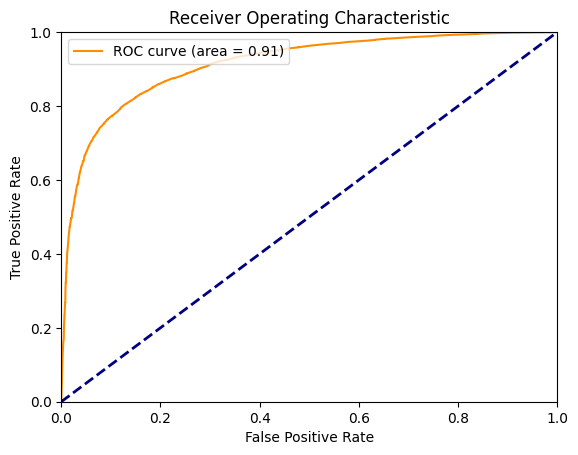



Accuracy score of the model 0.8774654172244534
Classification report 

              precision    recall  f1-score   support

           0       0.65      0.69      0.67      4058
           1       0.93      0.92      0.92     18352

    accuracy                           0.88     22410
   macro avg       0.79      0.80      0.80     22410
weighted avg       0.88      0.88      0.88     22410



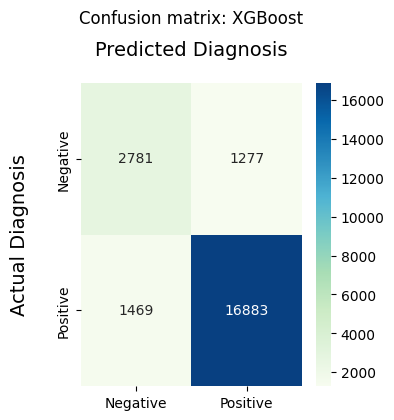

In [22]:
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score, f1_score, precision_score, recall_score
# Function to get roc curve
def get_roc (y_test,y_pred):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    #Plot of a ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="upper left")
    plt.show()
    return

def model_performance(y_test,y_pred, method):

    # calculate the accruacy of the model
    print("Accuracy score of the model", accuracy_score(y_test,y_pred))
    print("Classification report \n")

    #generate the classification report
    print(classification_report(y_test,y_pred))

    #generate the confusion matrix
    fig = plt.figure(figsize = (4,4))
    ax = fig.gca()
    cnf_matrix_log = confusion_matrix(y_test, y_pred)
    sns.heatmap(pd.DataFrame(cnf_matrix_log), annot=True,cmap="GnBu" , fmt='g')
    ax.xaxis.set_label_position("top")
    ax.xaxis.set_ticklabels(['Negative', 'Positive'])
    ax.yaxis.set_ticklabels(['Negative', 'Positive'])
    ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
    ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
    plt.tight_layout()
    plt.title('Confusion matrix: '+  method + '\n', y=1.1)

get_roc (Y_test, y_pred_proba)
print('\n')
model_performance(Y_test, y_test_pred, 'XGBoost')